## 1. Importing Necessary Modules and Libraries

In [46]:
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import InceptionV3, VGG19, Xception
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator



## 2. Class Definitions

### 2.1 Configuration

In [47]:
class Configuration:
    def __init__(self):
        self.data_dir = 'C:/Users/nofia/pcd/Deteksi buah/dataset_buah'
        self.output_dir = 'C:/Users/nofia/pcd/Deteksi buah/output'
        self.image_size = (224,224)
        self.batch_size = 32
        self.num_classes = 3
        self.optimizer = Adam
        self.learning_rate = 0.001
        self.epochs = 20
        self.loss = CategoricalCrossentropy()
        self.metrics = ['categorical_accuracy', 'precision', 'recall', 'auc']

In [48]:
# PATH DATASET (LOCAL WINDOWS)
base = "dataset_buah"   # <- INI KUNCI UTAMA

if not os.path.exists(base):
    raise FileNotFoundError("Folder dataset tidak ditemukan: " + os.path.abspath(base))

print("Lokasi dataset:", os.path.abspath(base))
print("Isi dataset:", os.listdir(base))

IMG_SIZE = (224, 224)
BATCH_SIZE = 16

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    base,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    base,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

print("Kelas terdeteksi:", train_gen.class_indices)


Lokasi dataset: C:\Users\nofia\pcd\Deteksi buah\dataset_buah
Isi dataset: ['Test', 'Train']
Found 3692 images belonging to 2 classes.
Found 922 images belonging to 2 classes.
Kelas terdeteksi: {'Test': 0, 'Train': 1}


### 2.2 DataLoader

In [49]:
class DataLoader:
    def __init__(self, data_dir, validation_split=0.1):
        self.train_dir = os.path.join(data_dir, 'Train')
        self.test_dir = os.path.join(data_dir, 'Test')
        
        self.train_datagen = ImageDataGenerator(rescale=1./255,
                                                validation_split=validation_split,
                                                rotation_range=30.0,
                                                width_shift_range=0.1,
                                                height_shift_range=0.1,
                                                shear_range=0.1,
                                                zoom_range=0.1,
                                                horizontal_flip=True,
                                                brightness_range=[0.8,1.2]
                                               )
        self.test_datagen = ImageDataGenerator(rescale=1./255)
        
    def get_training_data(self, image_size=(224,224), batch_size=32):
        print('Loading Training Data')
        train_generator = self.train_datagen.flow_from_directory(self.train_dir,
                                                                 target_size = image_size,
                                                                 class_mode = 'categorical',
                                                                 batch_size = batch_size,
                                                                 subset = 'training'
                                                                )
        print('Loading Validation Data')
        validation_generator = self.train_datagen.flow_from_directory(self.train_dir,
                                                                      target_size = image_size,
                                                                      class_mode = 'categorical',
                                                                      batch_size = batch_size,
                                                                      shuffle = True,
                                                                      subset = 'validation'
                                                                     )
        return train_generator, validation_generator
    
    def get_testing_data(self, image_size=(224,224), batch_size=32):
        print('Loading Test Data')
        test_generator = self.test_datagen.flow_from_directory(self.test_dir,
                                                               target_size = image_size,
                                                               class_mode = 'categorical',
                                                               batch_size = batch_size,
                                                               shuffle = False
                                                              )
        return test_generator

### 2.3 Visualizer

In [50]:
class Visualizer:
    def __init__(self):
        pass
        
    def pieplot(self, subplot, data, title):
        classes, count = np.unique(data.classes, return_counts=True)
        labels = data.class_indices.keys()
        subplot.pie(count, labels=labels, autopct='%.1f%%')
        subplot.set_title(title)
        
    def show_data_distribution(self, train, validation, test):
        fig, axes = plt.subplots(1,3, figsize=(12, 6))
        
        self.pieplot(axes[0], train, 'Training set')
        self.pieplot(axes[1], validation, 'Validation set')
        self.pieplot(axes[2], test, 'Test set')
        
        plt.show()
        
    def show_confusion_matrix(self, y_true, y_pred, labels):
        cm = confusion_matrix(y_true, y_pred)
        cm_df = pd.DataFrame(cm,
                             index = labels,
                             columns = labels
                            )
        sns.heatmap(cm_df,
                    annot=True,
                    cbar=False,
                    fmt='g',
                    cmap="viridis"
                   )
        plt.title('Confusion Matrix')
        plt.ylabel('Actal Values')
        plt.xlabel('Predicted Values')
        plt.show()
        
    def show_classification_report(self, y_true, y_pred, labels):
        print("Classification Report")
        print("===========================================\n")
        print(classification_report(y_true, y_pred, target_names=labels ))

### 2.4 PretrainedModel

In [51]:
class PretrainedModel:
    def __init__(self, image_size, num_classes, base_model, name=None):
        self.image_size = image_size
        self.input_shape = image_size + (3,)
        self.num_classes = num_classes
        
        # Buat Sequential model + name
        self.model = Sequential(name=name)

        # Base model (misalnya VGG19)
        base_model_instance = base_model(
            weights='imagenet',
            include_top=False,
            input_shape=self.input_shape
        )

        # Freeze base model
        for layer in base_model_instance.layers:
            layer.trainable = False

        # Susun model
        self.model.add(base_model_instance)
        self.model.add(GlobalAveragePooling2D())
        self.model.add(Dense(256, activation='relu', name='new_dense_1'))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(128, activation='relu', name='new_dense_2'))
        self.model.add(Dense(self.num_classes, activation='softmax', name='new_output'))

    def compile(self, optimizer, loss, metrics):
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    def summary(self):
        self.model.summary()

    def call(self, inputs):
        return self.model(inputs)
        
    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)

## 3. Initialization

In [52]:
#tf.keras.utils.set_random_seed = 500

conf = Configuration()
dataloader = DataLoader(conf.data_dir)
visualizer = Visualizer()

### 3.1 Hyperparameters

In [53]:
conf.image_size = (224,224)
conf.learning_rate = 0.001
conf.batch_size = 64
conf.epochs = 30

## 4. Loading Dataset

### 4.1 Training and Validation Data

In [54]:
train_gen, val_gen = dataloader.get_training_data(image_size=conf.image_size, batch_size=conf.batch_size)

Loading Training Data
Found 3992 images belonging to 3 classes.
Loading Validation Data
Found 442 images belonging to 3 classes.


### 4.2 Testing Data

In [55]:
test_gen = dataloader.get_testing_data(image_size=conf.image_size, batch_size=conf.batch_size)

Loading Test Data
Found 180 images belonging to 3 classes.


### 4.3 Data Distribution

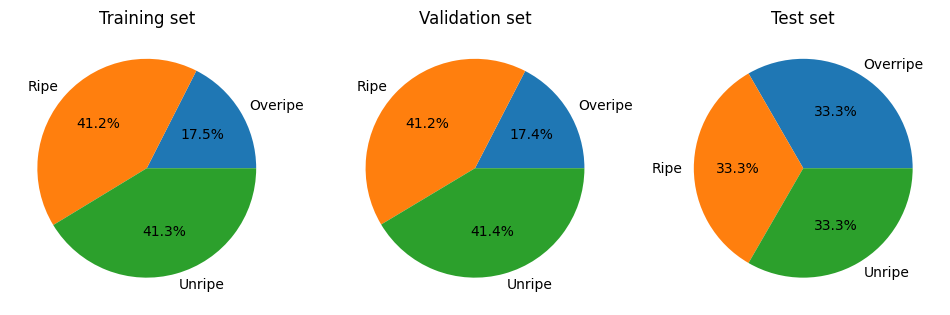

In [56]:
visualizer.show_data_distribution(train_gen, val_gen, test_gen)

## 5. Building Models

### 5.1 Inception V3 Pretrained Model

In [57]:
inception = PretrainedModel(image_size=conf.image_size,
                                  num_classes=conf.num_classes,
                                  base_model=InceptionV3
                                 )
inception.model.compile(optimizer=conf.optimizer(learning_rate=conf.learning_rate),
                        loss=conf.loss,
                        metrics=conf.metrics
                       )
inception.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ new_dense_1 (Dense)                  │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ new_dense_2 (Dense)                  │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ new_output (Dense)                   │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,360,611 (85.30 MB)

 Trainable params: 557,827 (2.13 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

### 5.2 VGG 19 Pretrained Model

In [58]:
vgg_model = PretrainedModel(
    image_size=conf.image_size,
    num_classes=conf.num_classes,
    base_model=VGG19,
    name='Pretrained_VGG19'
)

vgg_model.compile(
    optimizer=conf.optimizer(learning_rate=conf.learning_rate),
    loss=conf.loss,
    metrics=conf.metrics
)

vgg_model.summary()

Model: "Pretrained_VGG19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 7, 7, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ new_dense_1 (Dense)                  │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ new_dense_2 (Dense)                  │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ new_output (Dense)                   │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,188,995 (77.01 MB)

 Trainable params: 164,611 (643.01 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

### 5.3 Xception Pretrained Model

In [59]:
xception_model = PretrainedModel(image_size=conf.image_size,
                            num_classes=conf.num_classes,
                            base_model=Xception,
                            name='Pretrained_Xception'
                           )
xception_model.compile(optimizer=conf.optimizer(learning_rate=conf.learning_rate),
                  loss=conf.loss,
                  metrics=conf.metrics
                 )
xception_model.summary()

Model: "Pretrained_Xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 7, 7, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ new_dense_1 (Dense)                  │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ new_dense_2 (Dense)                  │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ new_output (Dense)                   │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,419,307 (81.71 MB)

 Trainable params: 557,827 (2.13 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

## 6. Training

### 6.1 Inception V3 Pretrained

In [31]:
inception_history = inception.model.fit(train_gen,
                                        validation_data=val_gen,
                                         epochs=conf.epochs,
                                        verbose=1
                                       )

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 323s 5s/step - auc: 0.8734 - categorical_accuracy: 0.7064 - loss: 0.6893 - precision: 0.7372 - recall: 0.6470 - val_auc: 0.8833 - val_categorical_accuracy: 0.6968 - val_loss: 0.6404 - val_precision: 0.7150 - val_recall: 0.6697
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 277s 4s/step - auc: 0.9411 - categorical_accuracy: 0.8109 - loss: 0.4614 - precision: 0.8257 - recall: 0.7913 - val_auc: 0.8761 - val_categorical_accuracy: 0.6923 - val_loss: 0.6660 - val_precision: 0.7221 - val_recall: 0.6584
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 316s 5s/step - auc: 0.9463 - categorical_accuracy: 0.8221 - loss: 0.4397 - precision: 0.8345 - recall: 0.8086 - val_auc: 0.8375 - val_categorical_accuracy: 0.6833 - val_loss: 0.7825 - val_precision: 0.6973 - val_recall: 0.6516
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 296s 5s/step - auc: 0.9565 - categorical_accuracy: 0.8402 - loss: 0.3966 - precision: 0.8502 - recall: 0.8231 - val_auc: 0.8745 - val_categorical_accuracy: 0.6991 - va

### 6.2 VGG 19 Pretrained

In [18]:
train_gen.reset()
val_gen.reset()

In [19]:
vgg_history = vgg_model.model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=conf.epochs,
    verbose=1
)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1506s 24s/step - auc: 0.7227 - categorical_accuracy: 0.5268 - loss: 0.9575 - precision: 0.6161 - recall: 0.3204 - val_auc: 0.7121 - val_categorical_accuracy: 0.4615 - val_loss: 0.9374 - val_precision: 0.4750 - val_recall: 0.3869
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1460s 23s/step - auc: 0.8249 - categorical_accuracy: 0.6293 - loss: 0.7828 - precision: 0.6965 - recall: 0.5158 - val_auc: 0.7777 - val_categorical_accuracy: 0.5407 - val_loss: 0.8646 - val_precision: 0.5474 - val_recall: 0.5226
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1388s 22s/step - auc: 0.8746 - categorical_accuracy: 0.6986 - loss: 0.6733 - precision: 0.7421 - recall: 0.6330 - val_auc: 0.8079 - val_categorical_accuracy: 0.5928 - val_loss: 0.8051 - val_precision: 0.6233 - val_recall: 0.5090
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 10381s 167s/step - auc: 0.8980 - categorical_accuracy: 0.7375 - loss: 0.6116 - precision: 0.7685 - recall: 0.6869 - val_auc: 0.7949 - val_categorical_accuracy: 0

### 6.3 Xception Pretrained

In [18]:
train_gen.reset()
val_gen.reset()

In [19]:
xception_history = xception_model.fit(train_gen,
                            validation_data=val_gen,
                            epochs=conf.epochs,
                            verbose=1
                           )

C:\Users\nofia\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 455s 7s/step - auc: 0.9261 - categorical_accuracy: 0.7768 - loss: 0.5198 - precision: 0.8083 - recall: 0.7332 - val_auc: 0.9089 - val_categorical_accuracy: 0.7647 - val_loss: 0.5709 - val_precision: 0.7680 - val_recall: 0.7489
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 493s 8s/step - auc: 0.9633 - categorical_accuracy: 0.8640 - loss: 0.3635 - precision: 0.8718 - recall: 0.8532 - val_auc: 0.9001 - val_categorical_accuracy: 0.7579 - val_loss: 0.6222 - val_precision: 0.7627 - val_recall: 0.7489
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 485s 8s/step - auc: 0.9717 - categorical_accuracy: 0.8725 - loss: 0.3156 - precision: 0.8779 - recall: 0.8667 - val_auc: 0.8801 - val_categorical_accuracy: 0.7240 - val_loss: 0.6813 - val_precision: 0.7412 - val_recall: 0.7127
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 463s 7s/step - auc: 0.9774 - categorical_accuracy: 0.8933 - loss: 0.2809 - precision: 0.8986 - recall: 0.8875 - val_auc: 0.9224 - val_categorical_accuracy: 0.7941 - va

## 7. Evaluation on Test Data

### 7.1 Inception V3 Pretrained

In [69]:
y_pred_inception = inception.model.predict(test_gen)

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step


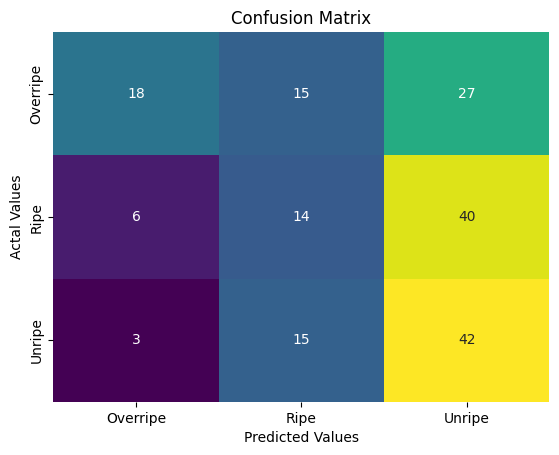

In [70]:
visualizer.show_confusion_matrix(test_gen.labels, y_pred_inception.argmax(axis=1), labels=test_gen.class_indices.keys())

In [71]:
visualizer.show_classification_report(test_gen.labels, y_pred_inception.argmax(axis=1), test_gen.class_indices.keys())

Classification Report

              precision    recall  f1-score   support

    Overripe       0.67      0.30      0.41        60
        Ripe       0.32      0.23      0.27        60
      Unripe       0.39      0.70      0.50        60

    accuracy                           0.41       180
   macro avg       0.46      0.41      0.39       180
weighted avg       0.46      0.41      0.39       180



In [72]:
print(inception.model.metrics_names)

['loss', 'compile_metrics']


In [73]:
print(conf.metrics)

['categorical_accuracy', 'precision', 'recall', 'auc']


In [74]:
test_gen.reset()
results = inception.model.evaluate(
    test_gen,
    verbose=1,
    return_dict=True
)

print("Akurasi Inception:",
      results['categorical_accuracy'] * 100, "%")


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - auc: 0.6220 - categorical_accuracy: 0.4111 - loss: 1.0507 - precision: 0.4909 - recall: 0.1500
Akurasi Inception: 41.111111640930176 %


### 7.2 VGG 19 Pretrained

3/3 ━━━━━━━━━━━━━━━━━━━━ 48s 15s/step


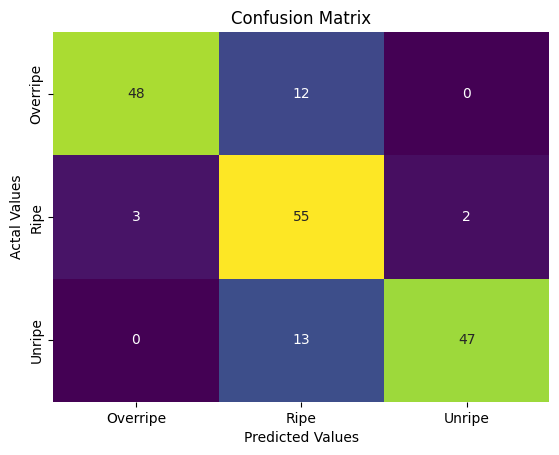

Classification Report

              precision    recall  f1-score   support

    Overripe       0.94      0.80      0.86        60
        Ripe       0.69      0.92      0.79        60
      Unripe       0.96      0.78      0.86        60

    accuracy                           0.83       180
   macro avg       0.86      0.83      0.84       180
weighted avg       0.86      0.83      0.84       180



In [26]:
# Ambil model keras dari wrapper
vgg_keras = vgg_model.model

# Reset generator biar urutan label aman
test_gen.reset()

# Prediksi
y_pred_vgg = vgg_keras.predict(test_gen)
y_pred_vgg_cls = y_pred_vgg.argmax(axis=1)

# Evaluasi
visualizer.show_confusion_matrix(
    test_gen.labels,
    y_pred_vgg_cls,
    labels=list(test_gen.class_indices.keys())
)

visualizer.show_classification_report(
    test_gen.labels,
    y_pred_vgg_cls,
    list(test_gen.class_indices.keys())
)


In [46]:
# Ekstrak keras model dari wrapper
vgg_keras = vgg_model.model

test_gen.reset()

results_vgg = vgg_keras.evaluate(
    test_gen,
    verbose=1,
    return_dict=True
)

print(f"Akurasi VGG19 : {results_vgg['categorical_accuracy'] * 100:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 41s 11s/step - auc: 0.9601 - categorical_accuracy: 0.8333 - loss: 0.3721 - precision: 0.8315 - recall: 0.8222
Akurasi VGG19 : 83.33%


### 7.3 Xception Pretrained

3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step


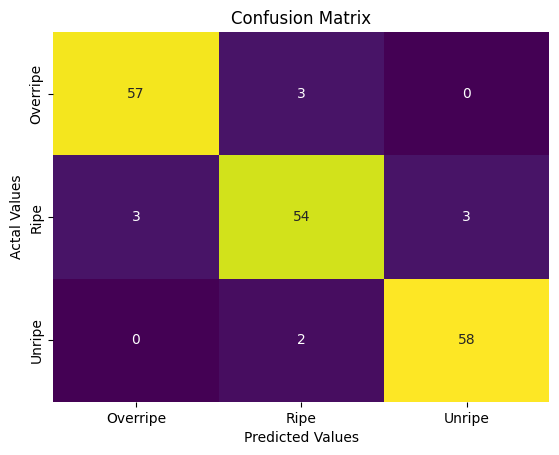

Classification Report

              precision    recall  f1-score   support

    Overripe       0.95      0.95      0.95        60
        Ripe       0.92      0.90      0.91        60
      Unripe       0.95      0.97      0.96        60

    accuracy                           0.94       180
   macro avg       0.94      0.94      0.94       180
weighted avg       0.94      0.94      0.94       180



In [21]:
# Ambil model keras dari wrapper
xception_keras = xception_model.model

# Reset generator agar sinkron
test_gen.reset()

# Prediksi
y_pred_xception = xception_keras.predict(test_gen)
y_pred_xception_cls = y_pred_xception.argmax(axis=1)

# Evaluasi
visualizer.show_confusion_matrix(
    test_gen.labels,
    y_pred_xception_cls,
    labels=list(test_gen.class_indices.keys())
)

visualizer.show_classification_report(
    test_gen.labels,
    y_pred_xception_cls,
    list(test_gen.class_indices.keys())
)


In [22]:
# Ambil keras model dari wrapper
xception_keras = xception_model.model

test_gen.reset()

results_xception = xception_keras.evaluate(
    test_gen,
    verbose=1,
    return_dict=True
)

print(f"Akurasi Xception : {results_xception['categorical_accuracy'] * 100:.2f}%")



3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 6s/step - auc: 0.9878 - categorical_accuracy: 0.9389 - loss: 0.1966 - precision: 0.9389 - recall: 0.9389
Akurasi Xception : 93.89%


In [23]:
# Ambil model keras dari wrapper
xception_keras = xception_model.model

# Reset generator agar sinkron
test_gen.reset()

# Label asli
y_true = test_gen.labels

# Prediksi probabilitas dari Xception
y_score = xception_keras.predict(test_gen)

# Jumlah kelas (3 kelas)
num_classes = conf.num_classes

3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step


In [24]:
#Binarisasi label (WAJIB untuk AUC multiclass)
y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))

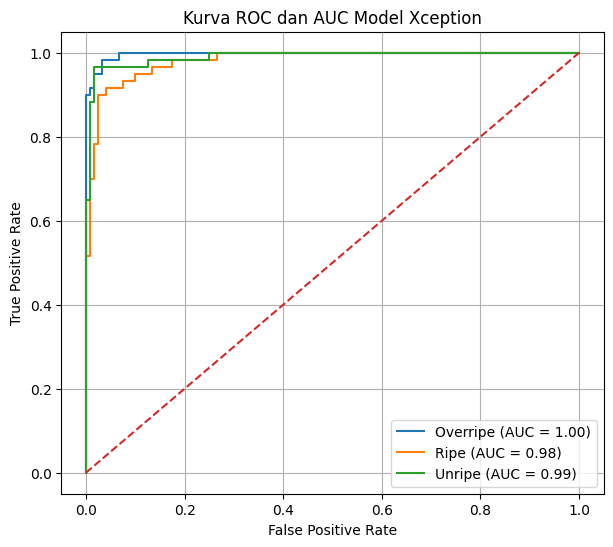

In [25]:
#Plot ROC dan AUC
plt.figure(figsize=(7,6))

for i, class_name in enumerate(test_gen.class_indices.keys()):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

# Garis baseline (model acak)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Kurva ROC dan AUC Model Xception')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [75]:
# Ambil model keras dari wrapper
inception.model = inception.model

In [76]:
inception.model.save(
    r'C:/Users/nofia/pcd/Deteksi buah/inception_224_0.0001_128_30.keras')

vgg_model.model.save(
    r'C:/Users/nofia/pcd/Deteksi buah/vgg_224_0.0001_128_30.keras')

xception_model.model.save(
    r'C:/Users/nofia/pcd/Deteksi buah/xception_224_0.0001_128_30.keras')


In [77]:
inception.model.save('inception_model.h5')

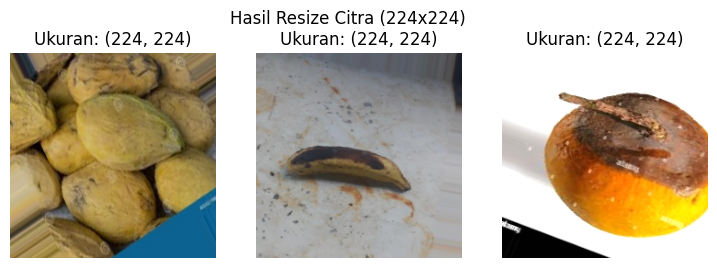

In [26]:
#menampilkan hasil resize citra

import matplotlib.pyplot as plt

# Ambil 1 batch data
images, labels = next(train_gen)

# Tampilkan 3 contoh citra hasil resize
plt.figure(figsize=(9,3))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(images[i])
    plt.title(f"Ukuran: {images[i].shape[:2]}")
    plt.axis('off')
plt.suptitle("Hasil Resize Citra (224x224)")
plt.show()


In [27]:
rescale = 1./255

# Nilai piksel sebelum & sesudah normalisasi
print("Nilai minimum piksel:", images.min())
print("Nilai maksimum piksel:", images.max())


Nilai minimum piksel: 0.0
Nilai maksimum piksel: 1.0


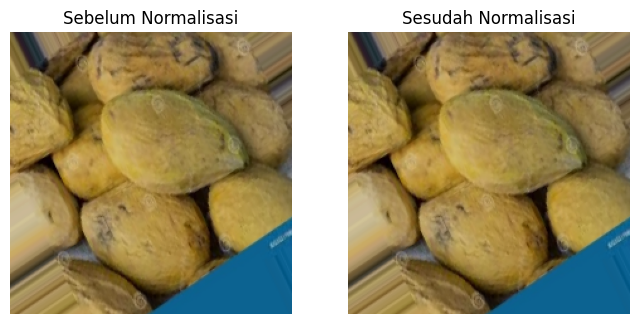

In [28]:
# Ambil satu citra
img_norm = images[0]
img_asli = img_norm * 255  # kembalikan ke skala asli

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(img_asli.astype('uint8'))
plt.title("Sebelum Normalisasi")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_norm)
plt.title("Sesudah Normalisasi")
plt.axis('off')

plt.show()


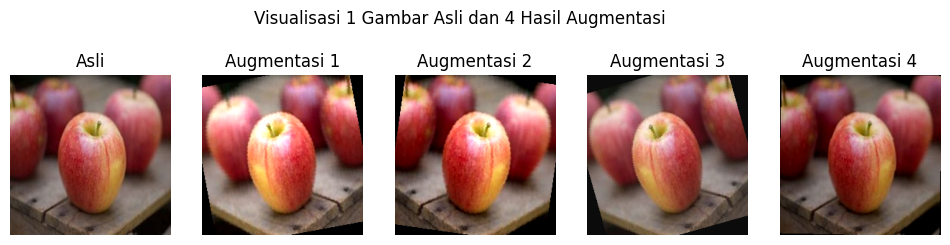

In [29]:
#Vsualisasi augmentasi

import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image

# =========================
# LOAD GAMBAR ASLI
# =========================
img_path = "dataset_buah/train/ripe/apple_ripe_017.jpg"  # ganti sesuai nama file
img = Image.open(img_path).convert("RGB")

# =========================
# TRANSFORM AUGMENTASI
# =========================
augment = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.ToTensor()
])

# =========================
# VISUALISASI
# =========================
plt.figure(figsize=(12, 3))

# Gambar Asli
plt.subplot(1, 5, 1)
plt.imshow(img.resize((224, 224)))
plt.title("Asli")
plt.axis("off")

# 4 Augmentasi
for i in range(4):
    aug_img = augment(img)
    plt.subplot(1, 5, i + 2)
    plt.imshow(aug_img.permute(1, 2, 0))
    plt.title(f"Augmentasi {i+1}")
    plt.axis("off")

plt.suptitle("Visualisasi 1 Gambar Asli dan 4 Hasil Augmentasi", fontsize=12)
plt.show()


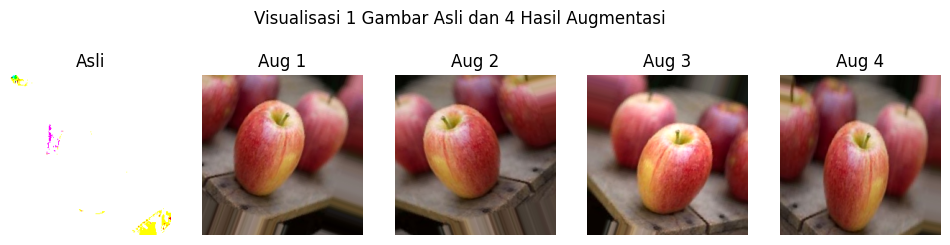

In [78]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np

# =========================
# LOAD 1 GAMBAR SAJA
# =========================
img_path = "dataset_buah/train/ripe/apple_ripe_017.jpg"  # ganti sesuai nama file
img = load_img(img_path, target_size=(224,224))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# =========================
# IMAGE DATA GENERATOR
# =========================
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

# =========================
# VISUALISASI
# =========================
plt.figure(figsize=(12,3))

# Gambar asli
plt.subplot(1,5,1)
plt.imshow(img_array[0])
plt.title("Asli")
plt.axis("off")

# 4 hasil augmentasi dari gambar yang sama
aug_iter = datagen.flow(img_array, batch_size=1)

for i in range(4):
    aug_img = next(aug_iter)
    plt.subplot(1,5,i+2)
    plt.imshow(aug_img[0])
    plt.title(f"Aug {i+1}")
    plt.axis("off")

plt.suptitle("Visualisasi 1 Gambar Asli dan 4 Hasil Augmentasi")
plt.show()
